In this notebook we implement a simple VAE with the reparameterisation trick and the fundamental trick.

In [1]:
import numpy, matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

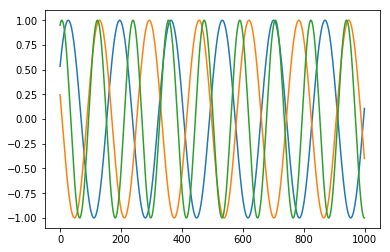

In [2]:
N = 10000
D = 1000
xs = numpy.linspace(0, 10 * numpy.pi, D)[None, :]
dataset = numpy.sin(numpy.random.uniform(0, 2 * numpy.pi, (N, 1)) + numpy.random.uniform(1, 2, (N, 1)) * xs)
plt.plot(dataset[:3].T)

In [3]:
import torch, torch.nn as nn

In [4]:
mseloss = nn.MSELoss()

class VAE(nn.Module):
    def __init__(self, input_size, hidden_size, kl_weight=1):
        super().__init__()
        self.input_size = self.n = input_size
        self.hidden_size = self.k = hidden_size
        self.kl_weight = kl_weight
        
        self.encoder = nn.Sequential(
            nn.Linear(self.n, self.k * 2),
            nn.Tanh(),
            nn.Linear(self.k * 2, self.k * 2),
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.k, self.k),
            nn.Tanh(),
            nn.Linear(self.k, self.n),
        )
    
    def forward(self, x):
        # Encode
        x = self.encoder(x)
        x = x.view(-1, 2, self.k)
        # Reparameterisation trick
        mu = x[:, 0]
        sigma = x[:, 1]
        sigma = sigma.mul(0.5).exp_()
        eps = torch.DoubleTensor(sigma.size()).normal_()
        eps = torch.autograd.Variable(eps)
        x = eps.mul(sigma).add_(mu)
        # Decode
        x = self.decoder(x)
        return x, mu, sigma
    
    def loss(self, recon_x, x, mu, logvar):
        BCE = mseloss(recon_x, x)
        KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
        KLD = torch.sum(KLD_element).mul_(-0.5)
        return BCE + self.kl_weight * KLD, self.kl_weight * KLD.item(), BCE.item()

In [5]:
model = VAE(D, 5, kl_weight=1e-6).double()

In [6]:
losses = []
klds = []
mses = []

In [7]:
optimiser = torch.optim.Adadelta(model.parameters(), lr=2e-1)

In [8]:
%matplotlib notebook
import matplotlib
matplotlib.rcParams['figure.dpi']

100.0

<IPython.core.display.Javascript object>


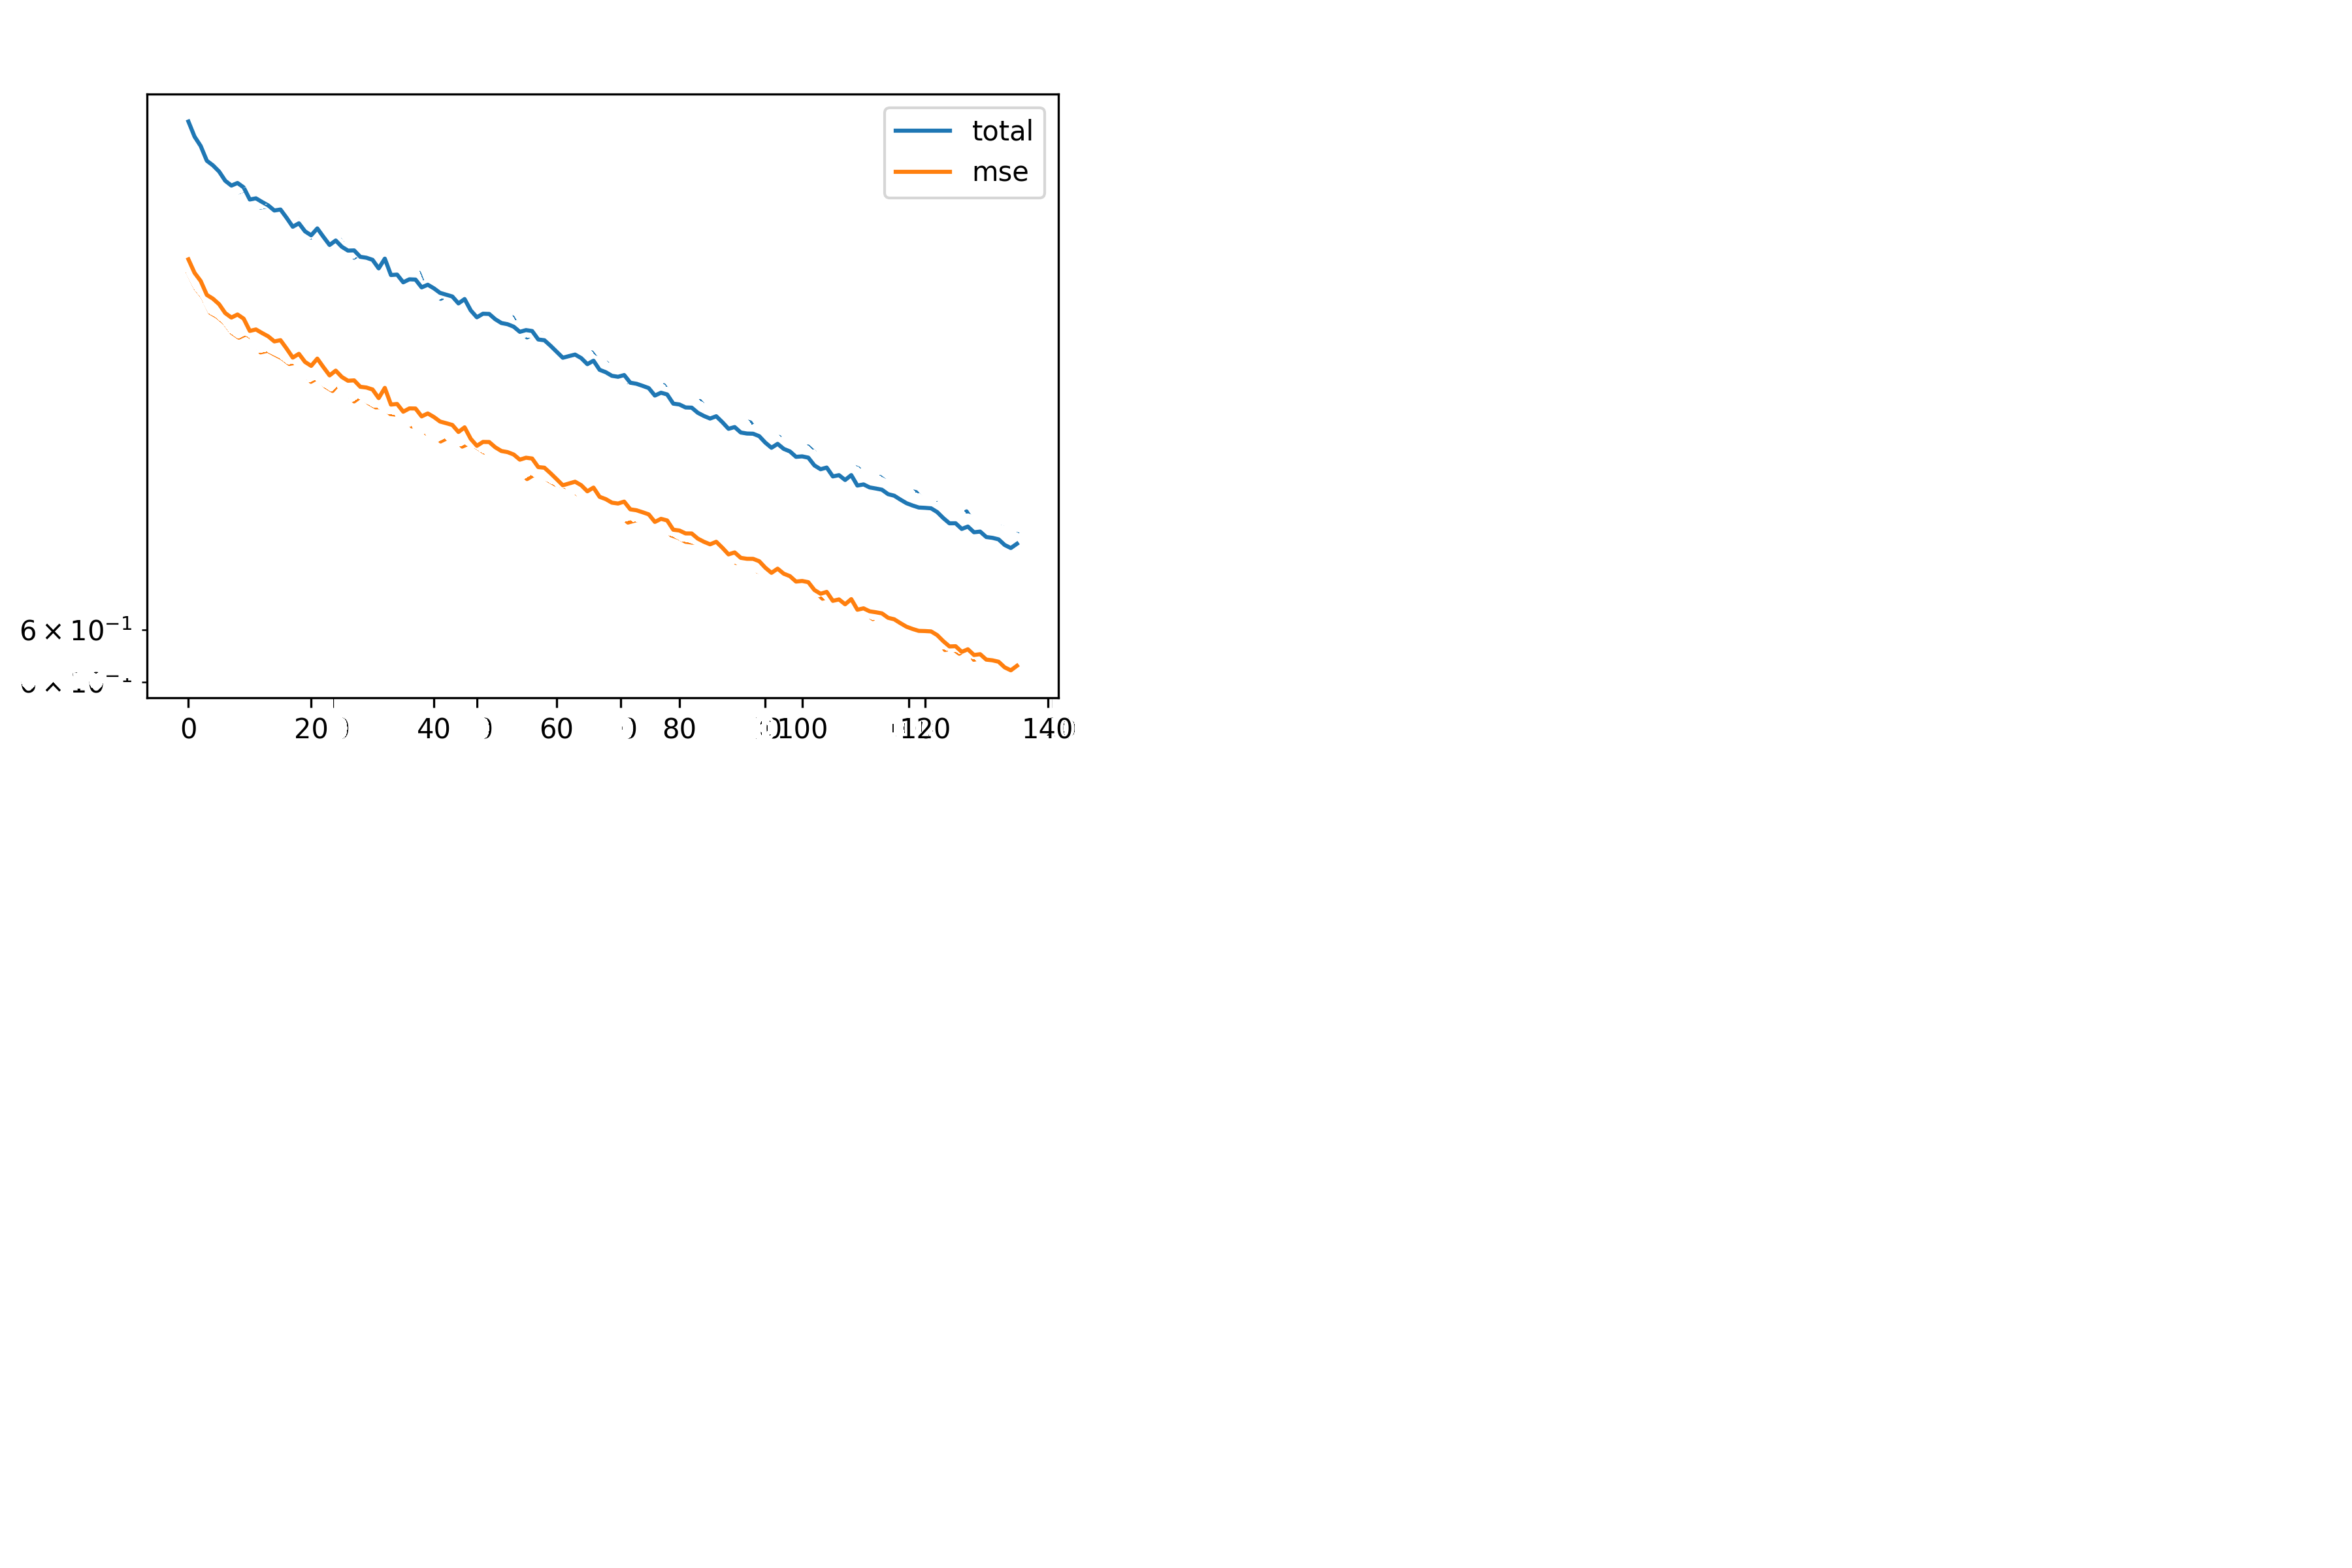

In [ ]:
fig = plt.figure(figsize=(6, 4), dpi=300)
plot_loss, = plt.plot(losses, label='total')
plot_mse, = plt.plot(mses, label='mse')
# plot_kld, = plt.plot(klds, label='kld')
plt.gca().set_yscale('log')
plt.legend(loc='best')

n_epochs = 100
torch_dataset = torch.autograd.Variable(torch.from_numpy(dataset))
shuffle = numpy.arange(len(torch_dataset))
bar = tqdm(total=n_epochs)
for epoch in range(n_epochs):
    model.train()
    numpy.random.shuffle(shuffle)
    optimiser.zero_grad()
    recon, mu, sigma = model.forward(torch_dataset[shuffle])
    loss, kld_loss, mse_loss = model.loss(recon, torch_dataset[shuffle], mu, sigma)
    loss.backward()
    loss_data = loss.item()
    losses.append(loss_data)
    klds.append(kld_loss)
    mses.append(mse_loss)
    optimiser.step()
    bar.update()
    bar.postfix = ' {:.6f}'.format(loss_data)
    plot_loss.set_data(range(len(losses)), numpy.array(losses))
    plot_mse.set_data(range(len(losses)), numpy.array(mses))
#     plot_kld.set_data(range(len(losses)), numpy.array(klds))
    fig.gca().relim()
    fig.gca().autoscale_view()
    fig.canvas.draw()

<IPython.core.display.Javascript object>


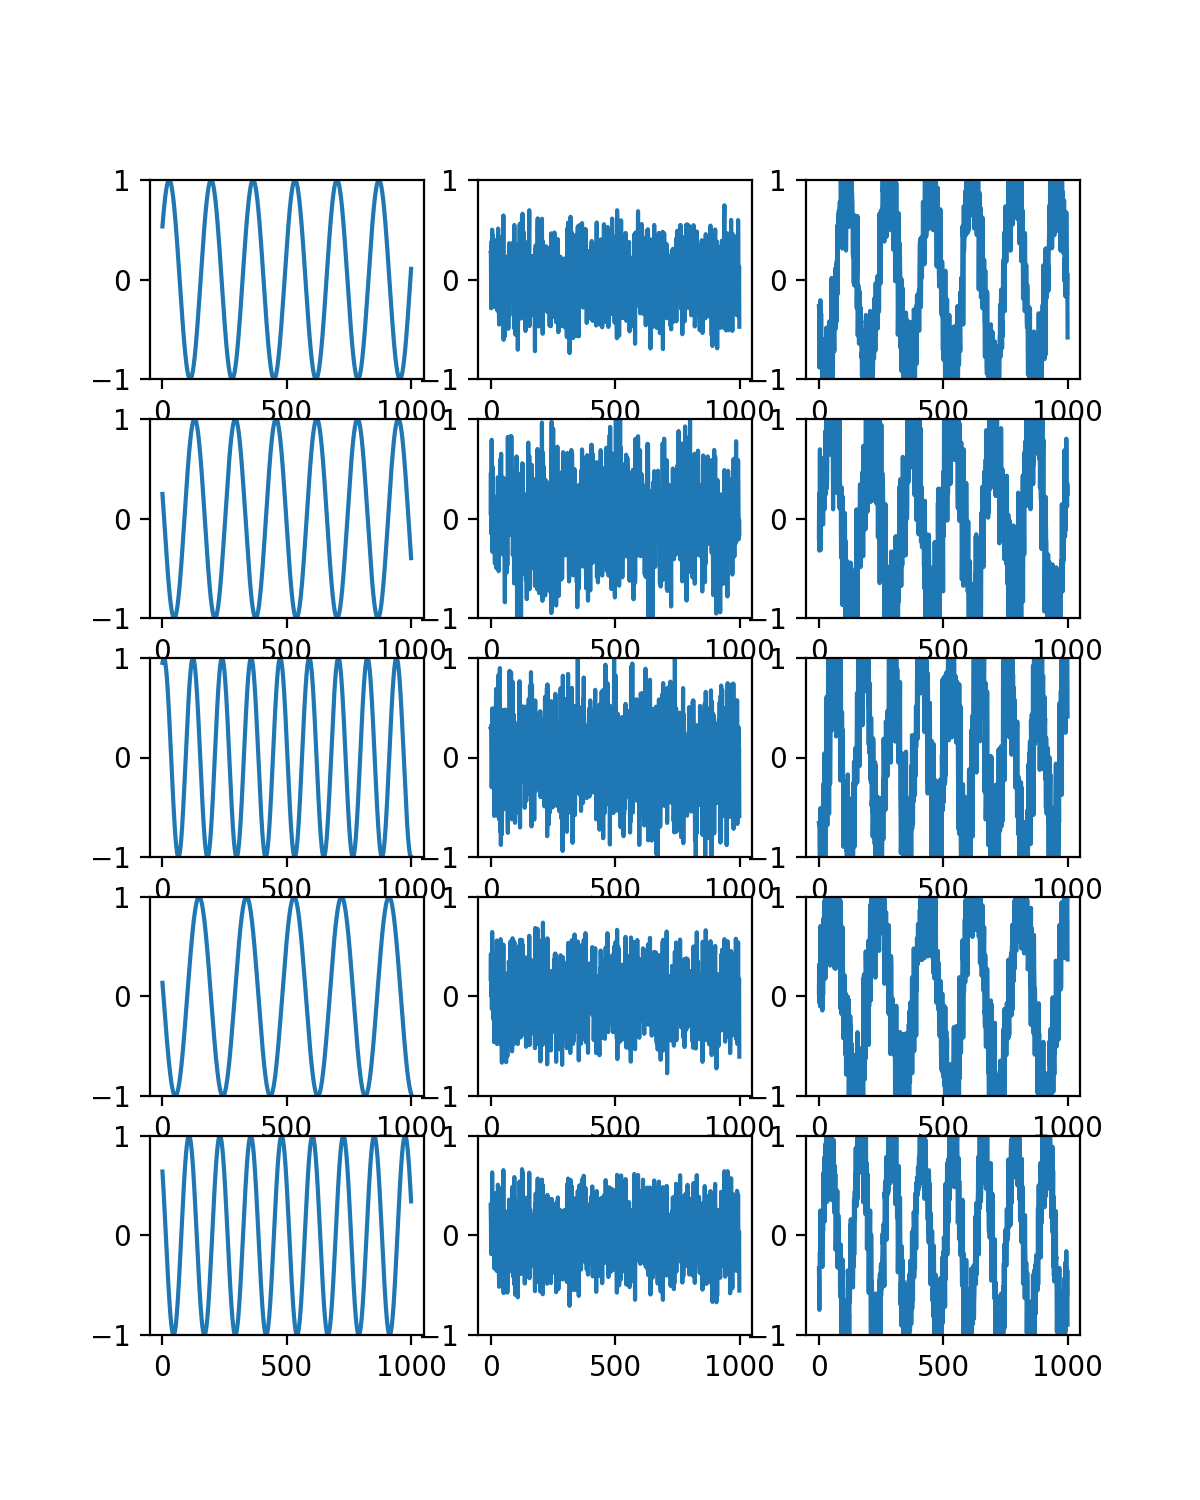

In [10]:
N = 5
recon = model.forward(torch.from_numpy(dataset[:10]))[0]
plt.figure(figsize=(6, N * 1.5))
for i in range(N):
    plt.subplot(N, 3, 1 + i * 3)
    plt.plot(dataset[i])
    plt.ylim(-1, 1)
    plt.subplot(N, 3, 2 + i * 3)
    plt.plot(recon[i].detach().numpy())
    plt.ylim(-1, 1)
    plt.subplot(N, 3, 3 + i * 3)
    plt.plot(recon[i].detach().numpy() - dataset[i])
    plt.ylim(-1, 1)

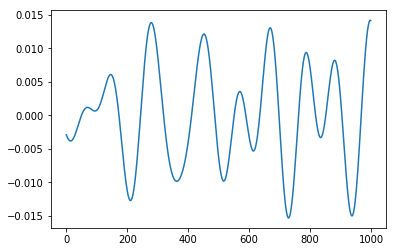

In [37]:
plt.plot(numpy.mean(dataset, axis=0))